In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

### 1. Data Cleaning

In [2]:
df = pd.read_csv("diabetes.csv")

In [3]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [7]:
duplicate_rows_data = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape[0])

number of duplicate rows:  0


In [6]:
df = df.drop_duplicates()

In [8]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [8]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

gender: 3 distinct values
age: 102 distinct values
hypertension: 2 distinct values
heart_disease: 2 distinct values
smoking_history: 6 distinct values
bmi: 4247 distinct values
HbA1c_level: 18 distinct values
blood_glucose_level: 18 distinct values
diabetes: 2 distinct values


In [9]:
df.describe().style.format("{:.2f}")

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96146.00,96146.00,96146.00,96146.00,96146.00,96146.00,96146.00
mean,41.79,0.08,0.04,27.32,5.53,138.22,0.09
std,22.46,0.27,0.20,6.77,1.07,40.91,0.28
min,0.08,0.00,0.00,10.01,3.50,80.00,0.00
25%,24.00,0.00,0.00,23.40,4.80,100.00,0.00
50%,43.00,0.00,0.00,27.32,5.80,140.00,0.00
75%,59.00,0.00,0.00,29.86,6.20,159.00,0.00
max,80.00,1.00,1.00,95.69,9.00,300.00,1.00


In [10]:
non_integer_ages = df[df['age'] % 1 != 0]
non_integer_ages

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
155,Female,0.08,0,0,No Info,14.43,6.5,160,0
218,Female,0.56,0,0,No Info,16.85,5.0,140,0
241,Male,0.88,0,0,No Info,17.49,6.0,140,0
268,Female,0.16,0,0,No Info,12.15,6.6,100,0
396,Male,0.16,0,0,No Info,14.35,6.5,126,0
...,...,...,...,...,...,...,...,...,...
99536,Female,0.40,0,0,No Info,16.66,3.5,140,0
99629,Female,0.64,0,0,No Info,17.58,6.1,140,0
99778,Female,0.32,0,0,No Info,12.26,5.8,126,0
99911,Female,0.32,0,0,No Info,18.37,3.5,80,0


In [11]:
df = df[df["age"] % 1 == 0]
df.shape

(94133, 9)

In [12]:
df["gender"].value_counts()

gender
Female    55176
Male      38939
Other        18
Name: count, dtype: int64

In [13]:
df = df[df["gender"] != "Other"]

In [15]:
df["smoking_history"].value_counts()

smoking_history
never          34261
No Info        31024
former          9299
current         9192
not current     6342
ever            3997
Name: count, dtype: int64

In [16]:
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

# Apply the function to the 'smoking_history' column
df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)

df['smoking_history'].value_counts()

smoking_history
non-smoker     65285
past_smoker    19638
current         9192
Name: count, dtype: int64

### 2. Data Visualization

In [18]:
df2 = df[df["diabetes"] == 1]

In [20]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8482 entries, 6 to 99979
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               8482 non-null   object 
 1   age                  8482 non-null   float64
 2   hypertension         8482 non-null   int64  
 3   heart_disease        8482 non-null   int64  
 4   smoking_history      8482 non-null   object 
 5   bmi                  8482 non-null   float64
 6   HbA1c_level          8482 non-null   float64
 7   blood_glucose_level  8482 non-null   int64  
 8   diabetes             8482 non-null   int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 662.7+ KB


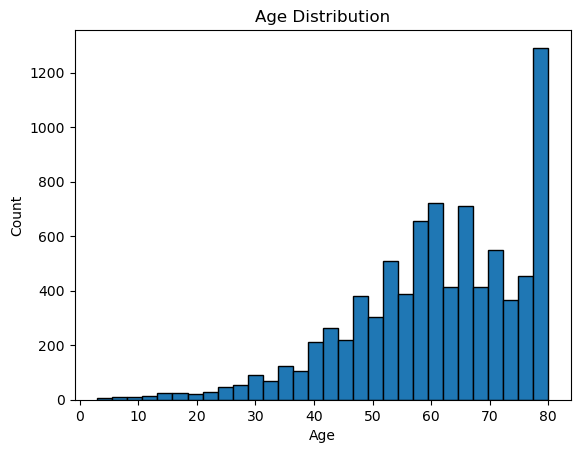

In [21]:
# Age
plt.hist(df2['age'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

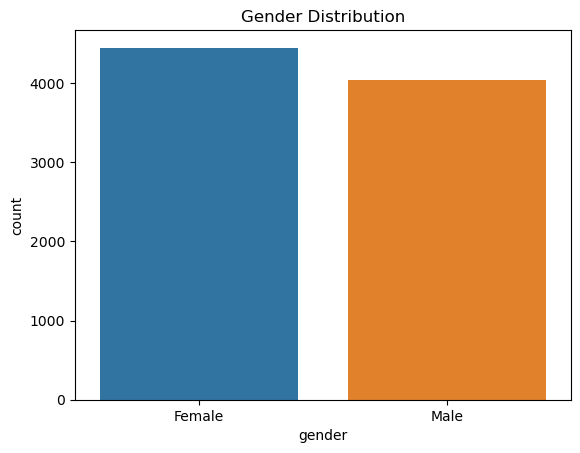

In [22]:
# Gender
sns.countplot(x='gender', data=df2)
plt.title('Gender Distribution')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


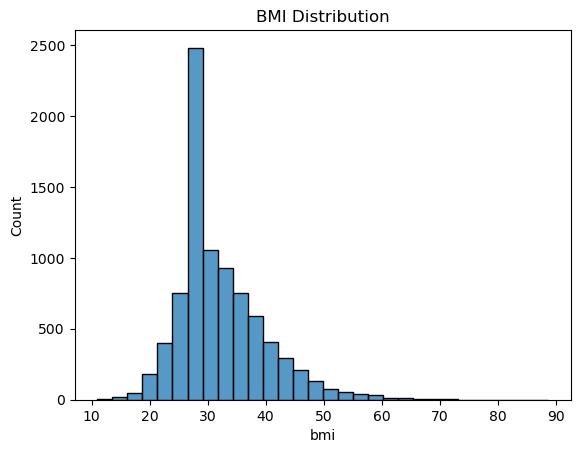

In [23]:
# Distribution plot for BMI
sns.histplot(df2['bmi'], bins=30)
plt.title('BMI Distribution')
plt.show()

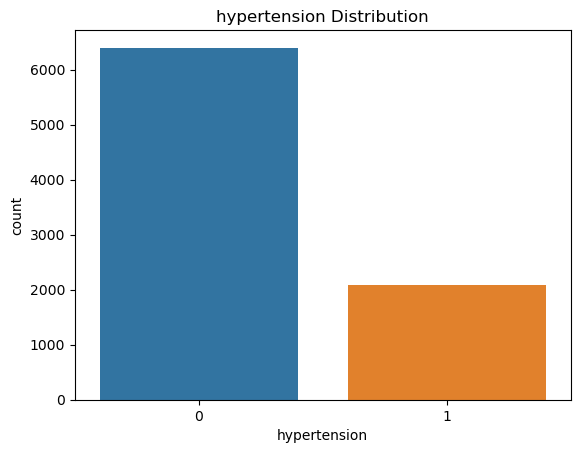

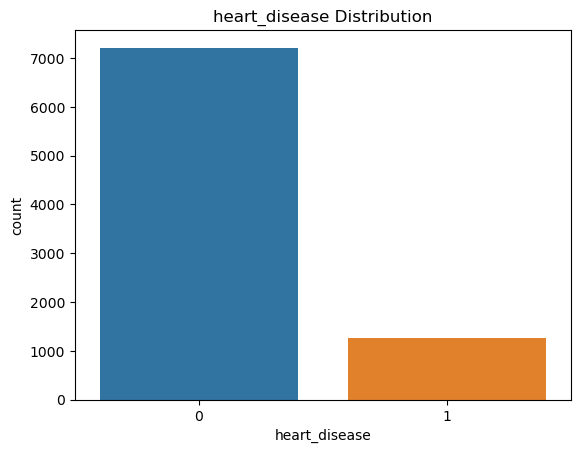

In [24]:
for col in ['hypertension', 'heart_disease']:
    sns.countplot(x=col, data=df2)
    plt.title(f'{col} Distribution')
    plt.show()

Boxplots

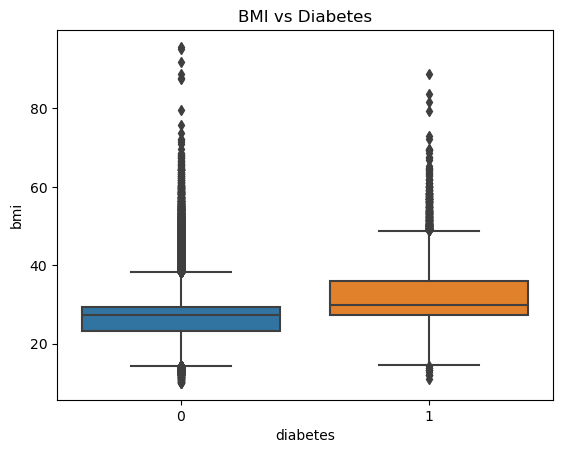

In [25]:
sns.boxplot(x='diabetes', y='bmi', data=df)
plt.title('BMI vs Diabetes')
plt.show()

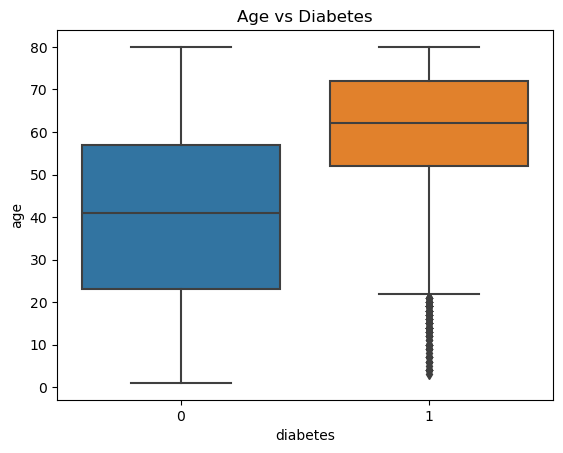

In [26]:
sns.boxplot(x='diabetes', y='age', data=df)
plt.title('Age vs Diabetes')
plt.show()

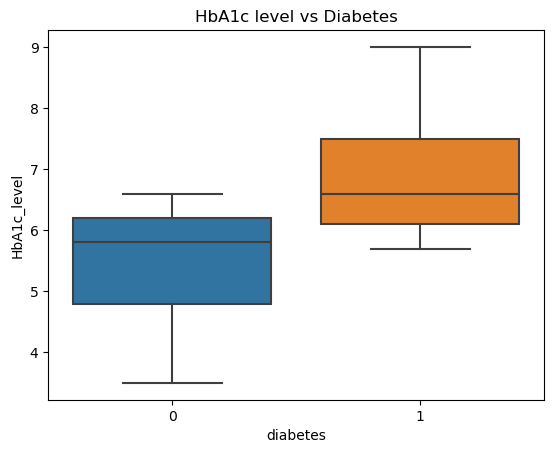

In [27]:
# Boxplot HbA1c level vs Diabetes classification
sns.boxplot(x='diabetes', y='HbA1c_level', data=df)
plt.title('HbA1c level vs Diabetes')
plt.show()

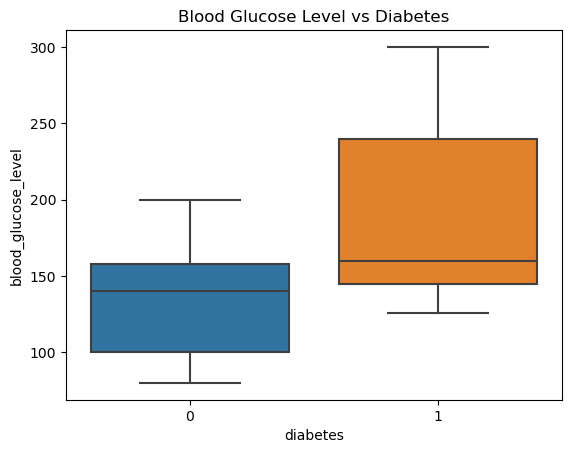

In [28]:
# Boxplot blood glucose level vs Diabetes classification
sns.boxplot(x='diabetes', y='blood_glucose_level', data=df)
plt.title('Blood Glucose Level vs Diabetes')
plt.show()

In [29]:
data = df.copy()

Correlation Matrix

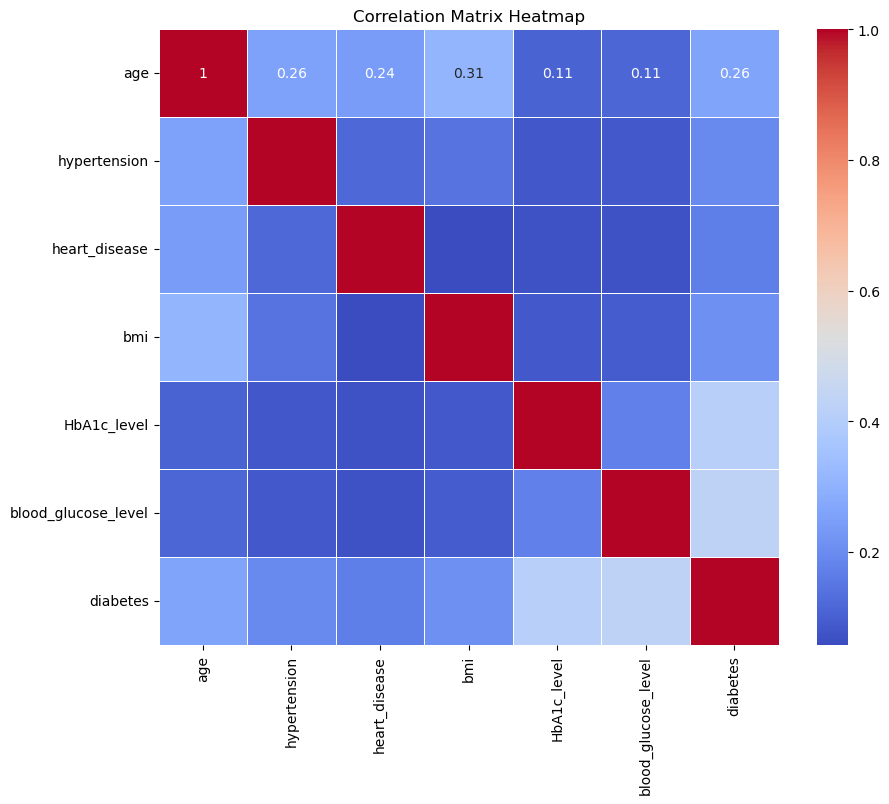

In [30]:
correlation_matrix = data.drop(["smoking_history", "gender"], axis=1).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

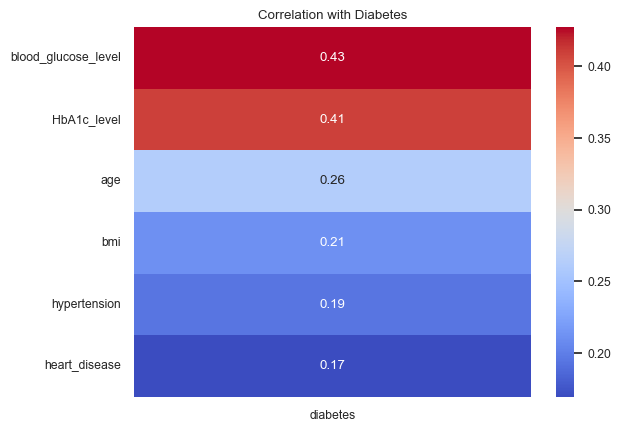

In [31]:
# Create a heatmap of the correlations with the target column
corr = data.drop(["smoking_history", "gender"], axis = 1).corr()
target_corr = corr['diabetes'].drop('diabetes')

target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

### 3. Data preparation

In [32]:
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1})
df = pd.get_dummies(columns=['smoking_history'], drop_first=True, data = df)

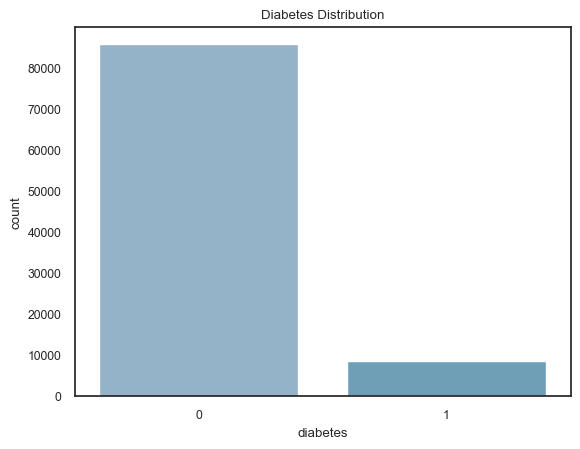

In [33]:
sns.countplot(x='diabetes', data=df)
plt.title('Diabetes Distribution')
plt.show()

In [34]:
X = df.drop('diabetes', axis=1)  
y = df['diabetes']               

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Class distribution after SMOTE:
diabetes
0    68535
1    68535
Name: count, dtype: int64


In [35]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

### 4. Model Building

#### 4.1 Logistic Regression

Confusion Matrix:
[[15352  1746]
 [  295  1430]]


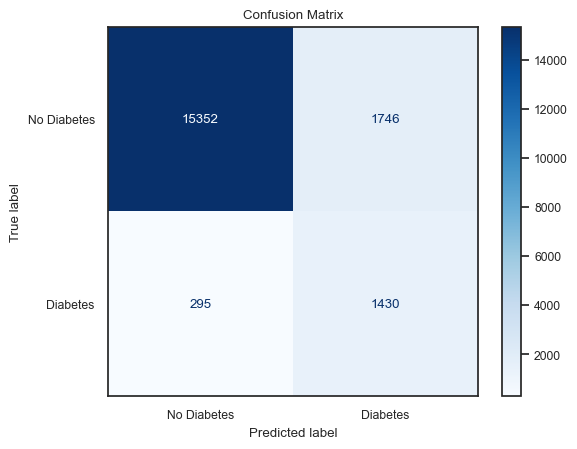


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     17098
           1       0.45      0.83      0.58      1725

    accuracy                           0.89     18823
   macro avg       0.72      0.86      0.76     18823
weighted avg       0.93      0.89      0.91     18823

Accuracy: 0.89
Precision: 0.45
Recall: 0.83
F1 Score: 0.58


In [36]:
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train_scaled, y_train_resampled)

y_pred_lr = log_reg.predict(X_test_scaled)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix:")
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['No Diabetes', 'Diabetes'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr):.2f}")

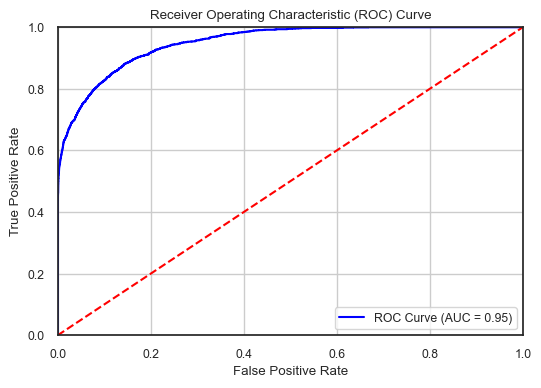

In [37]:
# ROC AUC
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

plot_roc_curve(log_reg, X_test_scaled, y_test)

In [38]:
# Grid Search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],        # Regularization 
}

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_scaled, y_train_resampled)

# Best Parameters
print("\nBest Parameters from GridSearchCV:")
print(grid_search.best_params_)
print(f"Best Cross-Validation Score: {grid_search.best_score_:.2f}")


Best Parameters from GridSearchCV:
{'C': 0.1, 'penalty': 'l2'}
Best Cross-Validation Score: 0.89


In [39]:
# Random Search
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(log_reg, param_grid, n_iter=7, cv=5, random_state=42)
random_search.fit(X_train_scaled, y_train_resampled)

print("\nBest Parameters from RandomizedSearchCV:")
print(random_search.best_params_)
print(f"Best Cross-Validation Score: {random_search.best_score_:.2f}")


Best Parameters from RandomizedSearchCV:
{'penalty': 'l2', 'C': 10}
Best Cross-Validation Score: 0.89


In [40]:
from sklearn.model_selection import cross_val_score

best_lr_classifier = grid_search.best_estimator_
cv_scores = cross_val_score(best_lr_classifier, X_train_scaled, y_train_resampled, cv=5, scoring='recall')

# Cross-validation scores
print("Cross-Validation AUC Scores:", cv_scores)
print(f"Mean Cross-Validation AUC: {cv_scores.mean():.2f}")

Cross-Validation AUC Scores: [0.85379733 0.90063471 0.91041074 0.90530386 0.89954038]
Mean Cross-Validation AUC: 0.89


In [41]:
# Feature importance
feature_names = X_train_resampled.columns

coefficients = best_lr_classifier.coef_[0]

lr_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance (Coefficient)': coefficients
}).sort_values(by='Importance (Coefficient)', key=abs, ascending=False)

lr_importance_df.reset_index(drop=True, inplace=True)
lr_importance_df

,Feature,Importance (Coefficient)
0,HbA1c_level,11.220354
1,blood_glucose_level,6.251696
2,bmi,5.937412
3,age,3.867048
4,smoking_history_past_smoker,2.114466
5,smoking_history_non-smoker,1.860551
6,gender,-0.435464
7,heart_disease,-0.322892
8,hypertension,-0.170935


#### 4.2 Decision Tree

Confusion Matrix:
[[16564   534]
 [  436  1289]]


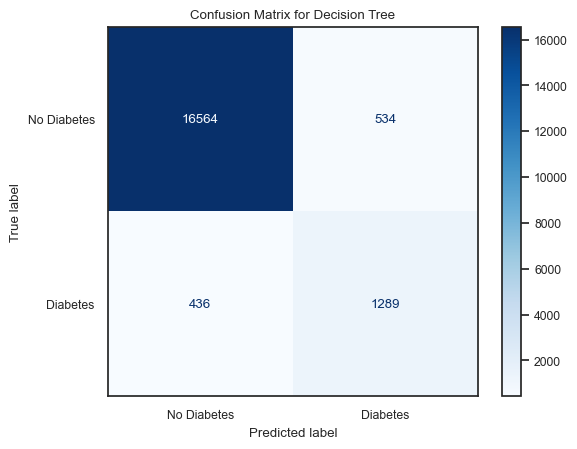


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     17098
           1       0.71      0.75      0.73      1725

    accuracy                           0.95     18823
   macro avg       0.84      0.86      0.85     18823
weighted avg       0.95      0.95      0.95     18823

Accuracy: 0.95
Precision: 0.71
Recall: 0.75
F1 Score: 0.73


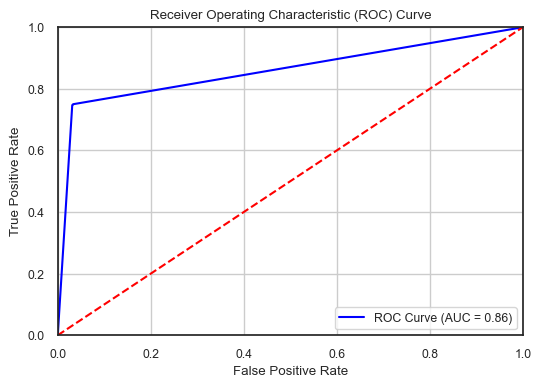

In [42]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_scaled, y_train_resampled)

y_pred_dt = dt_classifier.predict(X_test_scaled)

# Confusion Matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix:")
print(conf_matrix_dt)

disp_dt = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_dt, 
                                  display_labels=['No Diabetes', 'Diabetes'])
disp_dt.plot(cmap='Blues')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

# Results
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_dt):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_dt):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_dt):.2f}")

plot_roc_curve(dt_classifier, X_test_scaled, y_test)

In [46]:
# GridSearch
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV
grid_search_dt = GridSearchCV(estimator=dt_classifier, 
                           param_grid=param_grid, 
                           cv=5,  
                           n_jobs=-1, 
                           scoring='recall')

# Fit the model
grid_search_dt.fit(X_train_scaled, y_train_resampled)

# Best Parameters
print("\nBest Parameters from GridSearchCV:")
print(grid_search_dt.best_params_)
print(f"Best Cross-Validation Score: {grid_search_dt.best_score_:.2f}")

print("Best Parameters:", grid_search_dt.best_params_)


Best Parameters from GridSearchCV:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation Score: 0.97
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
# Cross-validation
best_dt_classifier = grid_search_dt.best_estimator_
cv_scores = cross_val_score(best_dt_classifier, X_train_scaled, y_train_resampled, cv=5, scoring='recall')

# Print cross-validation scores
print("Cross-Validation AUC Scores:", cv_scores)
print(f"Mean Cross-Validation AUC: {cv_scores.mean():.2f}")

Cross-Validation AUC Scores: [0.92867224 0.97772719 0.97749705 0.97586356 0.97714329]
Mean Cross-Validation AUC: 0.97


In [51]:
# Feature Importance

def get_feature_importance(model, feature_names):
    importance = model.feature_importances_

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    importance_df.reset_index(drop=True, inplace=True)
    return importance_df


dt_importance_df = get_feature_importance(best_dt_classifier, X_train_resampled.columns)
dt_importance_df 

,Feature,Importance
0,HbA1c_level,0.543819
1,blood_glucose_level,0.266834
2,age,0.104812
3,bmi,0.053786
4,smoking_history_non-smoker,0.012021
5,smoking_history_past_smoker,0.006627
6,gender,0.005740
7,hypertension,0.003732
8,heart_disease,0.002628


#### 4.3 Random Forest

Confusion Matrix:
[[16853   245]
 [  481  1244]]


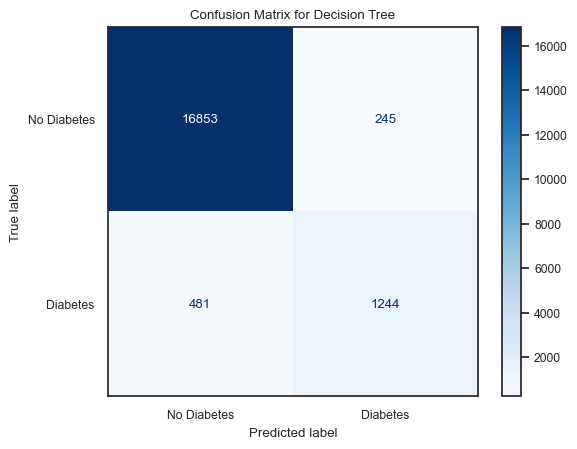


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17098
           1       0.84      0.72      0.77      1725

    accuracy                           0.96     18823
   macro avg       0.90      0.85      0.88     18823
weighted avg       0.96      0.96      0.96     18823

Accuracy: 0.96
Precision: 0.84
Recall: 0.72
F1 Score: 0.77


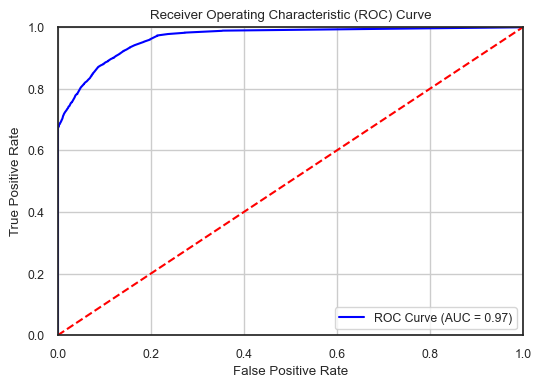

In [53]:
# Model Evaluation
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_scaled, y_train_resampled)

y_pred_rf = rf_classifier.predict(X_test_scaled)

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(conf_matrix_rf)

disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, 
                                  display_labels=['No Diabetes', 'Diabetes'])
disp_rf.plot(cmap='Blues')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

# Results
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.2f}")

plot_roc_curve(rf_classifier, X_test_scaled, y_test)

In [55]:
# Random Search

rf_param_grid = {
    'n_estimators': [20, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

random_search_rf = RandomizedSearchCV(rf_classifier, rf_param_grid, n_iter=5, cv=5, random_state=42, scoring='recall')
random_search_rf.fit(X_train_scaled, y_train_resampled)

print("\nBest Parameters from RandomizedSearchCV:")
print(random_search_rf.best_params_)
print(f"Best Cross-Validation Score: {random_search_rf.best_score_:.2f}")


Best Parameters from RandomizedSearchCV:
{'n_estimators': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'criterion': 'entropy'}
Best Cross-Validation Score: 0.97


In [57]:
# Cross-validation
best_rf_classifier = random_search_rf.best_estimator_
cv_scores = cross_val_score(best_rf_classifier, X_train_scaled, y_train_resampled, cv=5, scoring='recall')

# Print cross-validation scores
print("Cross-Validation AUC Scores:", cv_scores)
print(f"Mean Cross-Validation AUC: {cv_scores.mean():.2f}")

Cross-Validation AUC Scores: [0.87612169 0.98781644 0.98978624 0.98679507 0.98606551]
Mean Cross-Validation AUC: 0.97


In [58]:
best_rf_classifier

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=20, random_state=42)

In [59]:
# Feature Importance

rf_importance_df = get_feature_importance(best_rf_classifier, X_train_resampled.columns)
rf_importance_df 

,Feature,Importance
0,HbA1c_level,0.427806
1,blood_glucose_level,0.273395
2,age,0.157490
3,bmi,0.077300
4,smoking_history_non-smoker,0.029519
5,smoking_history_past_smoker,0.024336
6,gender,0.005796
7,hypertension,0.002763
8,heart_disease,0.001596


#### 4.4 XGBoost 

Confusion Matrix:
[[16853   245]
 [  481  1244]]


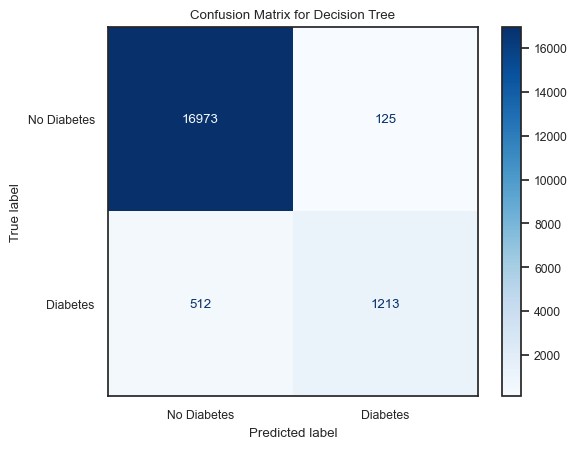


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17098
           1       0.91      0.70      0.79      1725

    accuracy                           0.97     18823
   macro avg       0.94      0.85      0.89     18823
weighted avg       0.96      0.97      0.96     18823

Accuracy: 0.97
Precision: 0.91
Recall: 0.70
F1 Score: 0.79


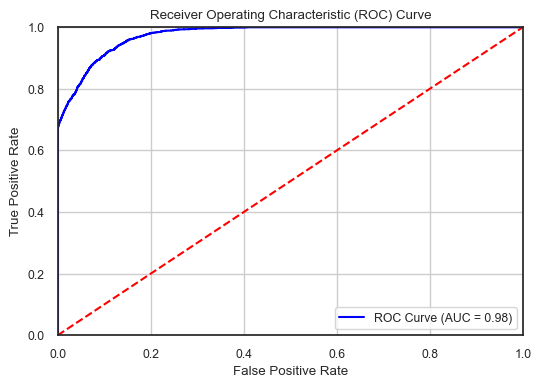

In [60]:
# Model Evaluation
xgb_classifier = XGBClassifier(random_state=42)
xgb_classifier.fit(X_train_scaled, y_train_resampled)

y_pred_xgb = xgb_classifier.predict(X_test_scaled)

# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:")
print(conf_matrix_rf)

disp_xgb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb, 
                                  display_labels=['No Diabetes', 'Diabetes'])
disp_xgb.plot(cmap='Blues')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

# Results
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.2f}")

plot_roc_curve(xgb_classifier, X_test_scaled, y_test)

In [61]:
# Random Search

xgb_param_grid = {
    'n_estimators': [20, 50, 100],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
}

random_search_xgb = RandomizedSearchCV(xgb_classifier, xgb_param_grid, n_iter=5, cv=5, random_state=42, scoring='recall')
random_search_xgb.fit(X_train_scaled, y_train_resampled)

print("\nBest Parameters from RandomizedSearchCV:")
print(random_search_rf.best_params_)
print(f"Best Cross-Validation Score: {random_search_rf.best_score_:.2f}")


Best Parameters from RandomizedSearchCV:
{'n_estimators': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'criterion': 'entropy'}
Best Cross-Validation Score: 0.97


In [62]:
# Cross-Validation

best_xgb_classifier = random_search_xgb.best_estimator_
cv_scores = cross_val_score(best_xgb_classifier, X_train_scaled, y_train_resampled, cv=5, scoring='recall')

# Print cross-validation scores
print("Cross-Validation AUC Scores:", cv_scores)
print(f"Mean Cross-Validation AUC: {cv_scores.mean():.2f}")

Cross-Validation AUC Scores: [0.85175458 0.95732108 0.96279273 0.95914496 0.96045816]
Mean Cross-Validation AUC: 0.94


In [64]:
# Feature Importance

xgb_importance_df = get_feature_importance(best_xgb_classifier, X_train_resampled.columns)
xgb_importance_df

,Feature,Importance
0,HbA1c_level,0.322690
1,blood_glucose_level,0.251977
2,smoking_history_non-smoker,0.246636
3,age,0.091819
4,smoking_history_past_smoker,0.046407
5,bmi,0.040471
6,gender,0.000000
7,hypertension,0.000000
8,heart_disease,0.000000


#### 4.5 Catboost

Learning rate set to 0.084219
0:	learn: 0.5130071	total: 12.5ms	remaining: 12.5s
1:	learn: 0.4015167	total: 26.7ms	remaining: 13.3s
2:	learn: 0.3327968	total: 36.3ms	remaining: 12.1s
3:	learn: 0.2976268	total: 47.4ms	remaining: 11.8s
4:	learn: 0.2499803	total: 56.9ms	remaining: 11.3s
5:	learn: 0.2238278	total: 66ms	remaining: 10.9s
6:	learn: 0.2007452	total: 75.4ms	remaining: 10.7s
7:	learn: 0.1895816	total: 85.1ms	remaining: 10.6s
8:	learn: 0.1810570	total: 94.7ms	remaining: 10.4s
9:	learn: 0.1701194	total: 105ms	remaining: 10.4s
10:	learn: 0.1631747	total: 116ms	remaining: 10.4s
11:	learn: 0.1566408	total: 125ms	remaining: 10.3s
12:	learn: 0.1522738	total: 134ms	remaining: 10.2s
13:	learn: 0.1464923	total: 144ms	remaining: 10.1s
14:	learn: 0.1428538	total: 154ms	remaining: 10.1s
15:	learn: 0.1375456	total: 163ms	remaining: 10.1s
16:	learn: 0.1326587	total: 174ms	remaining: 10s
17:	learn: 0.1310558	total: 183ms	remaining: 10s
18:	learn: 0.1261400	total: 194ms	remaining: 10s
19:	learn:

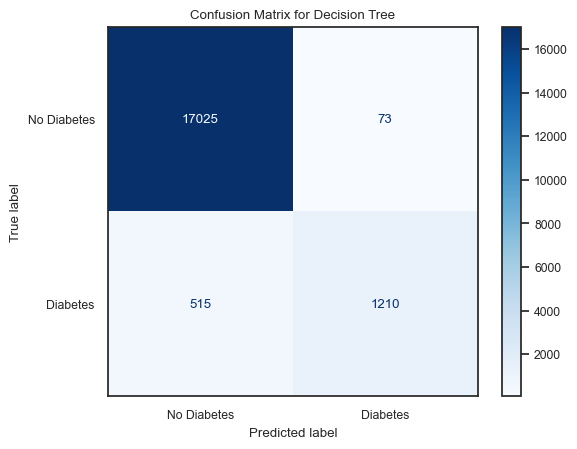


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17098
           1       0.94      0.70      0.80      1725

    accuracy                           0.97     18823
   macro avg       0.96      0.85      0.89     18823
weighted avg       0.97      0.97      0.97     18823

Accuracy: 0.97
Precision: 0.94
Recall: 0.70
F1 Score: 0.80


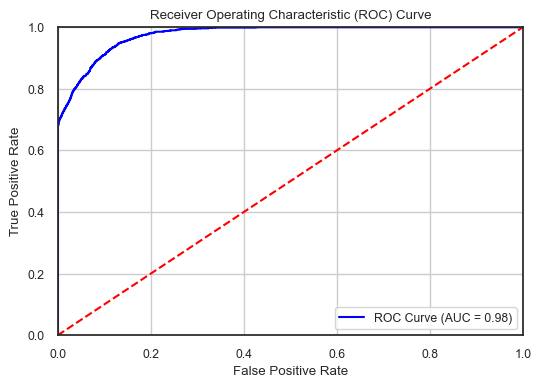

In [66]:
# Model Evaluation

cb_classifier = CatBoostClassifier(random_state=42)
cb_classifier.fit(X_train_scaled, y_train_resampled)

y_pred_cb = cb_classifier.predict(X_test_scaled)

# Confusion Matrix
conf_matrix_cb = confusion_matrix(y_test, y_pred_cb)
print("Confusion Matrix:")
print(conf_matrix_cb)

disp_cb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_cb, 
                                  display_labels=['No Diabetes', 'Diabetes'])
disp_cb.plot(cmap='Blues')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

# Results
print("\nClassification Report:")
print(classification_report(y_test, y_pred_cb))

print(f"Accuracy: {accuracy_score(y_test, y_pred_cb):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_cb):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_cb):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_cb):.2f}")

plot_roc_curve(cb_classifier, X_test_scaled, y_test)

In [68]:
# Random Search

cb_param_grid = {
    'iterations': [20, 50, 100],
    'depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0, 0.5, 1.0],
    'random_strength': [1, 2, 3]
}

random_search_cb = RandomizedSearchCV(cb_classifier, cb_param_grid, n_iter=8, cv=5, random_state=42, scoring='recall')
random_search_cb.fit(X_train_scaled, y_train_resampled)

print("\nBest Parameters from RandomizedSearchCV:")
print(random_search_cb.best_params_)
print(f"Best Cross-Validation Score: {random_search_cb.best_score_:.2f}")

0:	learn: 0.6253236	total: 4.5ms	remaining: 85.5ms
1:	learn: 0.5696530	total: 9.02ms	remaining: 81.2ms
2:	learn: 0.5229809	total: 18.5ms	remaining: 105ms
3:	learn: 0.4847787	total: 23.3ms	remaining: 93.1ms
4:	learn: 0.4508327	total: 26.6ms	remaining: 79.8ms
5:	learn: 0.4216699	total: 30.1ms	remaining: 70.2ms
6:	learn: 0.3963199	total: 33.5ms	remaining: 62.2ms
7:	learn: 0.3741512	total: 37.3ms	remaining: 56ms
8:	learn: 0.3560291	total: 40.5ms	remaining: 49.5ms
9:	learn: 0.3379770	total: 44.5ms	remaining: 44.5ms
10:	learn: 0.3220399	total: 47.9ms	remaining: 39.2ms
11:	learn: 0.3091219	total: 51.2ms	remaining: 34.1ms
12:	learn: 0.2946863	total: 54.9ms	remaining: 29.6ms
13:	learn: 0.2816547	total: 58.9ms	remaining: 25.2ms
14:	learn: 0.2714423	total: 62.6ms	remaining: 20.9ms
15:	learn: 0.2606422	total: 66.1ms	remaining: 16.5ms
16:	learn: 0.2505559	total: 69.5ms	remaining: 12.3ms
17:	learn: 0.2417017	total: 72.8ms	remaining: 8.09ms
18:	learn: 0.2348501	total: 76.9ms	remaining: 4.04ms
19:	lea

In [69]:
# Cross-Validation

best_cb_classifier = random_search_cb.best_estimator_
cv_scores = cross_val_score(best_cb_classifier, X_train_scaled, y_train_resampled, cv=5, scoring='recall')

# Print cross-validation scores
print("Cross-Validation AUC Scores:", cv_scores)
print(f"Mean Cross-Validation AUC: {cv_scores.mean():.2f}")

0:	learn: 0.5852685	total: 3.88ms	remaining: 384ms
1:	learn: 0.5103065	total: 6.66ms	remaining: 326ms
2:	learn: 0.4518274	total: 9.13ms	remaining: 295ms
3:	learn: 0.4085159	total: 12.1ms	remaining: 291ms
4:	learn: 0.3763518	total: 15.5ms	remaining: 294ms
5:	learn: 0.3479644	total: 18.1ms	remaining: 283ms
6:	learn: 0.3223885	total: 20.5ms	remaining: 272ms
7:	learn: 0.3033590	total: 22.9ms	remaining: 264ms
8:	learn: 0.2843136	total: 26.2ms	remaining: 265ms
9:	learn: 0.2695793	total: 28.9ms	remaining: 260ms
10:	learn: 0.2581506	total: 31.5ms	remaining: 255ms
11:	learn: 0.2474864	total: 38.6ms	remaining: 283ms
12:	learn: 0.2373379	total: 41.4ms	remaining: 277ms
13:	learn: 0.2300230	total: 44.1ms	remaining: 271ms
14:	learn: 0.2215178	total: 47ms	remaining: 266ms
15:	learn: 0.2148440	total: 49.6ms	remaining: 260ms
16:	learn: 0.2083088	total: 52ms	remaining: 254ms
17:	learn: 0.2025456	total: 54.2ms	remaining: 247ms
18:	learn: 0.1954867	total: 57.4ms	remaining: 245ms
19:	learn: 0.1915711	total

In [70]:
# Feature Importance

cb_importance_df = get_feature_importance(best_cb_classifier, X_train_resampled.columns)
cb_importance_df

,Feature,Importance
0,HbA1c_level,62.389130
1,blood_glucose_level,22.568030
2,age,5.931313
3,smoking_history_past_smoker,3.678369
4,smoking_history_non-smoker,2.780033
5,bmi,2.408151
6,gender,0.228742
7,heart_disease,0.016233
8,hypertension,0.000000
